In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_DO_BN(conv_num=1):
    init_channel = 64
    
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=init_channel, strides=1, 
                      padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=int(init_channel*(2**int((i+1)/3))), 
                          strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_DO_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1024000)           0         
_________________________________________________________________
dense (Dense)        

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_10 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_10 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_11 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_11 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 5333, 64)          0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_28 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_28 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_29 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_29 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 5333, 64)          0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1826 - acc: 0.3753
Epoch 00001: val_loss improved from inf to 1.52981, saving model to model/checkpoint/1D_CNN_custom_3_DO_BN_4_conv_checkpoint/001-1.5298.hdf5
36805/36805 [==============================] - 92s 3ms/sample - loss: 2.1825 - acc: 0.3753 - val_loss: 1.5298 - val_acc: 0.4990
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3878 - acc: 0.5745
Epoch 00002: val_loss improved from 1.52981 to 1.20548, saving model to model/checkpoint/1D_CNN_custom_3_DO_BN_4_conv_checkpoint/002-1.2055.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 1.3878 - acc: 0.5745 - val_loss: 1.2055 - val_acc: 0.6348
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1196 - acc: 0.6542
Epoch 00003: val_loss improved from 1.20548 to 1.19680, saving model to m

36800/36805 [============================>.] - ETA: 0s - loss: 0.1490 - acc: 0.9519
Epoch 00028: val_loss did not improve from 0.96305
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1491 - acc: 0.9519 - val_loss: 1.2593 - val_acc: 0.7272
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1373 - acc: 0.9563
Epoch 00029: val_loss did not improve from 0.96305
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1373 - acc: 0.9563 - val_loss: 1.3812 - val_acc: 0.7212
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1304 - acc: 0.9579
Epoch 00030: val_loss did not improve from 0.96305
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1305 - acc: 0.9579 - val_loss: 1.4110 - val_acc: 0.7167
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1390 - acc: 0.9557
Epoch 00031: val_loss did not improve from 0.96305
36805/36805 [========================

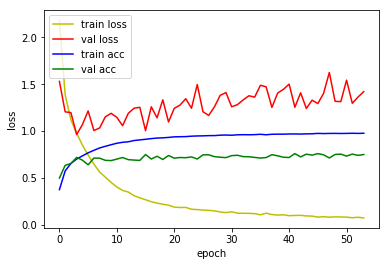

4815/4815 [==============================] - 19s 4ms/sample - loss: 5.6159 - acc: 0.4974
Loss: 5.615899310503174 Accuracy: 0.49740395

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0991 - acc: 0.3745
Epoch 00001: val_loss improved from inf to 1.50678, saving model to model/checkpoint/1D_CNN_custom_3_DO_BN_5_conv_checkpoint/001-1.5068.hdf5
36805/36805 [==============================] - 96s 3ms/sample - loss: 2.0992 - acc: 0.3744 - val_loss: 1.5068 - val_acc: 0.5083
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3306 - acc: 0.5855
Epoch 00002: val_loss improved from 1.50678 to 1.08817, saving model to model/checkpoint/1D_CNN_custom_3_DO_BN_5_conv_checkpoint/002-1.0882.hdf5
36805/36805 [==============================] - 92s 2ms/sample - loss: 1.3307 - acc: 0.5854 - val_loss: 1.0882 - val_acc: 0.6697
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0784 

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2359 - acc: 0.9232
Epoch 00028: val_loss did not improve from 0.64220
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.2359 - acc: 0.9231 - val_loss: 0.7162 - val_acc: 0.8134
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2309 - acc: 0.9255
Epoch 00029: val_loss did not improve from 0.64220
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.2309 - acc: 0.9255 - val_loss: 0.7840 - val_acc: 0.8001
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2161 - acc: 0.9306
Epoch 00030: val_loss did not improve from 0.64220
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.2161 - acc: 0.9306 - val_loss: 0.7178 - val_acc: 0.8150
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2125 - acc: 0.9315
Epoch 00031: val_loss did not improve from 0.64220
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.1056 - acc: 0.9661
Epoch 00057: val_loss did not improve from 0.61870
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.1056 - acc: 0.9661 - val_loss: 0.9532 - val_acc: 0.8043
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0968 - acc: 0.9697
Epoch 00058: val_loss did not improve from 0.61870
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0968 - acc: 0.9697 - val_loss: 0.7687 - val_acc: 0.8369
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1024 - acc: 0.9679
Epoch 00059: val_loss did not improve from 0.61870
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.1024 - acc: 0.9679 - val_loss: 0.7135 - val_acc: 0.8418
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0965 - acc: 0.9691
Epoch 00060: val_loss did not improve from 0.61870
36805/36805 [========================

Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0640 - acc: 0.9804
Epoch 00087: val_loss did not improve from 0.61870
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0640 - acc: 0.9804 - val_loss: 0.8938 - val_acc: 0.8293
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0643 - acc: 0.9807
Epoch 00088: val_loss did not improve from 0.61870
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0643 - acc: 0.9807 - val_loss: 0.8453 - val_acc: 0.8318
Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0658 - acc: 0.9806
Epoch 00089: val_loss did not improve from 0.61870
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0659 - acc: 0.9806 - val_loss: 0.7579 - val_acc: 0.8481
Epoch 90/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0741 - acc: 0.9777
Epoch 00090: val_loss did not improve from 0.61870
36805/36805 [===========

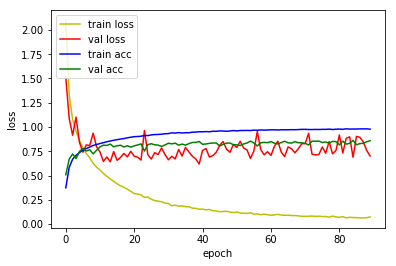

4815/4815 [==============================] - 5s 942us/sample - loss: 0.7763 - acc: 0.8108
Loss: 0.7762671216626034 Accuracy: 0.8107996

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1807 - acc: 0.3402
Epoch 00001: val_loss improved from inf to 1.61615, saving model to model/checkpoint/1D_CNN_custom_3_DO_BN_6_conv_checkpoint/001-1.6162.hdf5
36805/36805 [==============================] - 100s 3ms/sample - loss: 2.1806 - acc: 0.3402 - val_loss: 1.6162 - val_acc: 0.4694
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3191 - acc: 0.5850
Epoch 00002: val_loss improved from 1.61615 to 1.14666, saving model to model/checkpoint/1D_CNN_custom_3_DO_BN_6_conv_checkpoint/002-1.1467.hdf5
36805/36805 [==============================] - 93s 3ms/sample - loss: 1.3193 - acc: 0.5850 - val_loss: 1.1467 - val_acc: 0.6434
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.056

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2408 - acc: 0.9248
Epoch 00026: val_loss did not improve from 0.41949
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.2408 - acc: 0.9248 - val_loss: 0.4366 - val_acc: 0.8861
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2353 - acc: 0.9266
Epoch 00027: val_loss did not improve from 0.41949
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.2353 - acc: 0.9266 - val_loss: 0.4365 - val_acc: 0.8796
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2285 - acc: 0.9287
Epoch 00028: val_loss did not improve from 0.41949
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.2285 - acc: 0.9288 - val_loss: 0.4628 - val_acc: 0.8912
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2201 - acc: 0.9304
Epoch 00029: val_loss improved from 0.41949 to 0.38609, saving model to mod

36800/36805 [============================>.] - ETA: 0s - loss: 0.1007 - acc: 0.9684
Epoch 00055: val_loss did not improve from 0.36418
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.1007 - acc: 0.9684 - val_loss: 0.4619 - val_acc: 0.8915
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1025 - acc: 0.9673
Epoch 00056: val_loss did not improve from 0.36418
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.1025 - acc: 0.9673 - val_loss: 0.4146 - val_acc: 0.8954
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0973 - acc: 0.9681
Epoch 00057: val_loss did not improve from 0.36418
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0973 - acc: 0.9681 - val_loss: 0.4187 - val_acc: 0.9024
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1021 - acc: 0.9672
Epoch 00058: val_loss did not improve from 0.36418
36805/36805 [========================

Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0609 - acc: 0.9810
Epoch 00085: val_loss did not improve from 0.36418
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0611 - acc: 0.9810 - val_loss: 0.4412 - val_acc: 0.9024

1D_CNN_custom_3_DO_BN_6_conv Model


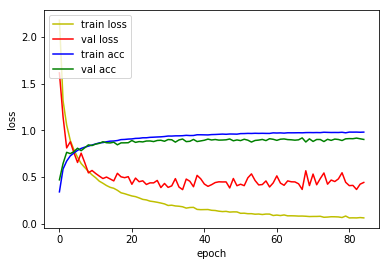

4815/4815 [==============================] - 5s 990us/sample - loss: 0.4635 - acc: 0.8719
Loss: 0.4635198420081926 Accuracy: 0.8718588

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0321 - acc: 0.3764
Epoch 00001: val_loss improved from inf to 1.30052, saving model to model/checkpoint/1D_CNN_custom_3_DO_BN_7_conv_checkpoint/001-1.3005.hdf5
36805/36805 [==============================] - 104s 3ms/sample - loss: 2.0319 - acc: 0.3764 - val_loss: 1.3005 - val_acc: 0.6026
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1452 - acc: 0.6374
Epoch 00002: val_loss improved from 1.30052 to 0.78826, saving model to model/checkpoint/1D_CNN_custom_3_DO_BN_7_conv_checkpoint/002-0.7883.hdf5
36805/36805 [==============================] - 95s 3ms/sample - loss: 1.1451 - acc: 0.6374 - val_loss: 0.7883 - val_acc: 0.7757
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.846

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1225 - acc: 0.9603
Epoch 00026: val_loss did not improve from 0.22856
36805/36805 [==============================] - 95s 3ms/sample - loss: 0.1226 - acc: 0.9603 - val_loss: 0.2800 - val_acc: 0.9255
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1220 - acc: 0.9601
Epoch 00027: val_loss did not improve from 0.22856
36805/36805 [==============================] - 95s 3ms/sample - loss: 0.1220 - acc: 0.9601 - val_loss: 0.2776 - val_acc: 0.9297
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1103 - acc: 0.9644
Epoch 00028: val_loss improved from 0.22856 to 0.22080, saving model to model/checkpoint/1D_CNN_custom_3_DO_BN_7_conv_checkpoint/028-0.2208.hdf5
36805/36805 [==============================] - 95s 3ms/sample - loss: 0.1103 - acc: 0.9644 - val_loss: 0.2208 - val_acc: 0.9378
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.

36800/36805 [============================>.] - ETA: 0s - loss: 0.0439 - acc: 0.9864
Epoch 00055: val_loss did not improve from 0.22080
36805/36805 [==============================] - 94s 3ms/sample - loss: 0.0440 - acc: 0.9863 - val_loss: 0.2378 - val_acc: 0.9432
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0470 - acc: 0.9844
Epoch 00056: val_loss did not improve from 0.22080
36805/36805 [==============================] - 95s 3ms/sample - loss: 0.0471 - acc: 0.9844 - val_loss: 0.2796 - val_acc: 0.9373
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0496 - acc: 0.9842
Epoch 00057: val_loss did not improve from 0.22080
36805/36805 [==============================] - 95s 3ms/sample - loss: 0.0496 - acc: 0.9842 - val_loss: 0.2506 - val_acc: 0.9439
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0356 - acc: 0.9887
Epoch 00058: val_loss did not improve from 0.22080
36805/36805 [========================

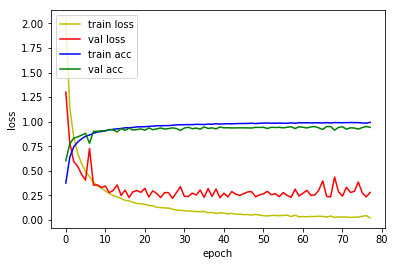

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2783 - acc: 0.9250
Loss: 0.27825931191815767 Accuracy: 0.92502594

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9280 - acc: 0.4151
Epoch 00001: val_loss improved from inf to 1.18389, saving model to model/checkpoint/1D_CNN_custom_3_DO_BN_8_conv_checkpoint/001-1.1839.hdf5
36805/36805 [==============================] - 109s 3ms/sample - loss: 1.9281 - acc: 0.4150 - val_loss: 1.1839 - val_acc: 0.6138
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9250 - acc: 0.7091
Epoch 00002: val_loss improved from 1.18389 to 0.55814, saving model to model/checkpoint/1D_CNN_custom_3_DO_BN_8_conv_checkpoint/002-0.5581.hdf5
36805/36805 [==============================] - 96s 3ms/sample - loss: 0.9249 - acc: 0.7091 - val_loss: 0.5581 - val_acc: 0.8372
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.622

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0636 - acc: 0.9800
Epoch 00026: val_loss did not improve from 0.14442
36805/36805 [==============================] - 96s 3ms/sample - loss: 0.0636 - acc: 0.9800 - val_loss: 0.1805 - val_acc: 0.9495
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0576 - acc: 0.9819
Epoch 00027: val_loss improved from 0.14442 to 0.13733, saving model to model/checkpoint/1D_CNN_custom_3_DO_BN_8_conv_checkpoint/027-0.1373.hdf5
36805/36805 [==============================] - 96s 3ms/sample - loss: 0.0576 - acc: 0.9819 - val_loss: 0.1373 - val_acc: 0.9604
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0581 - acc: 0.9818
Epoch 00028: val_loss improved from 0.13733 to 0.12918, saving model to model/checkpoint/1D_CNN_custom_3_DO_BN_8_conv_checkpoint/028-0.1292.hdf5
36805/36805 [==============================] - 96s 3ms/sample - loss: 0.0581 - acc: 0.9818 - val_loss: 0.1292 - 

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0160 - acc: 0.9958
Epoch 00055: val_loss did not improve from 0.12767
36805/36805 [==============================] - 95s 3ms/sample - loss: 0.0160 - acc: 0.9958 - val_loss: 0.1756 - val_acc: 0.9616
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0192 - acc: 0.9941
Epoch 00056: val_loss did not improve from 0.12767
36805/36805 [==============================] - 96s 3ms/sample - loss: 0.0192 - acc: 0.9941 - val_loss: 0.2026 - val_acc: 0.9488
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0191 - acc: 0.9943
Epoch 00057: val_loss did not improve from 0.12767
36805/36805 [==============================] - 96s 3ms/sample - loss: 0.0191 - acc: 0.9943 - val_loss: 0.1674 - val_acc: 0.9590
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0214 - acc: 0.9927
Epoch 00058: val_loss did not improve from 0.12767
36805/36805 [===========

Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0106 - acc: 0.9968
Epoch 00085: val_loss did not improve from 0.12767
36805/36805 [==============================] - 95s 3ms/sample - loss: 0.0106 - acc: 0.9968 - val_loss: 0.1727 - val_acc: 0.9651
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0122 - acc: 0.9963
Epoch 00086: val_loss did not improve from 0.12767
36805/36805 [==============================] - 96s 3ms/sample - loss: 0.0122 - acc: 0.9963 - val_loss: 0.1953 - val_acc: 0.9592
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0115 - acc: 0.9965
Epoch 00087: val_loss did not improve from 0.12767
36805/36805 [==============================] - 95s 3ms/sample - loss: 0.0118 - acc: 0.9965 - val_loss: 0.2999 - val_acc: 0.9413
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0314 - acc: 0.9902
Epoch 00088: val_loss did not improve from 0.12767
36805/36805 [===========

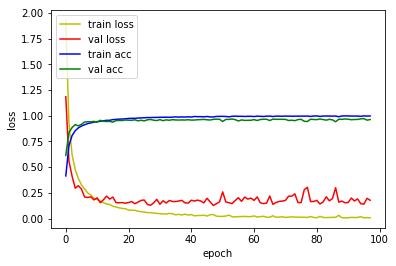

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.1704 - acc: 0.9516
Loss: 0.1703981090382492 Accuracy: 0.95160955

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5356 - acc: 0.5458
Epoch 00001: val_loss improved from inf to 0.99463, saving model to model/checkpoint/1D_CNN_custom_3_DO_BN_9_conv_checkpoint/001-0.9946.hdf5
36805/36805 [==============================] - 113s 3ms/sample - loss: 1.5357 - acc: 0.5458 - val_loss: 0.9946 - val_acc: 0.6716
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6330 - acc: 0.8024
Epoch 00002: val_loss improved from 0.99463 to 0.33392, saving model to model/checkpoint/1D_CNN_custom_3_DO_BN_9_conv_checkpoint/002-0.3339.hdf5
36805/36805 [==============================] - 96s 3ms/sample - loss: 0.6334 - acc: 0.8024 - val_loss: 0.3339 - val_acc: 0.9040
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4204

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0391 - acc: 0.9882
Epoch 00026: val_loss did not improve from 0.12497
36805/36805 [==============================] - 96s 3ms/sample - loss: 0.0391 - acc: 0.9882 - val_loss: 0.1859 - val_acc: 0.9520
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0414 - acc: 0.9872
Epoch 00027: val_loss did not improve from 0.12497
36805/36805 [==============================] - 96s 3ms/sample - loss: 0.0415 - acc: 0.9872 - val_loss: 0.1559 - val_acc: 0.9583
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0352 - acc: 0.9895
Epoch 00028: val_loss did not improve from 0.12497
36805/36805 [==============================] - 96s 3ms/sample - loss: 0.0352 - acc: 0.9895 - val_loss: 0.1359 - val_acc: 0.9651
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0355 - acc: 0.9892
Epoch 00029: val_loss did not improve from 0.12497
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0271 - acc: 0.9918
Epoch 00055: val_loss did not improve from 0.11871
36805/36805 [==============================] - 96s 3ms/sample - loss: 0.0271 - acc: 0.9918 - val_loss: 0.1257 - val_acc: 0.9697
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0093 - acc: 0.9973
Epoch 00056: val_loss did not improve from 0.11871
36805/36805 [==============================] - 96s 3ms/sample - loss: 0.0093 - acc: 0.9973 - val_loss: 0.1616 - val_acc: 0.9630
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0102 - acc: 0.9973
Epoch 00057: val_loss did not improve from 0.11871
36805/36805 [==============================] - 96s 3ms/sample - loss: 0.0102 - acc: 0.9973 - val_loss: 0.1342 - val_acc: 0.9693
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0151 - acc: 0.9955
Epoch 00058: val_loss did not improve from 0.11871
36805/36805 [========================

Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0087 - acc: 0.9973
Epoch 00085: val_loss did not improve from 0.11614
36805/36805 [==============================] - 96s 3ms/sample - loss: 0.0087 - acc: 0.9973 - val_loss: 0.1321 - val_acc: 0.9674
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0081 - acc: 0.9977
Epoch 00086: val_loss did not improve from 0.11614
36805/36805 [==============================] - 96s 3ms/sample - loss: 0.0081 - acc: 0.9977 - val_loss: 0.1360 - val_acc: 0.9700
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0068 - acc: 0.9978
Epoch 00087: val_loss did not improve from 0.11614
36805/36805 [==============================] - 96s 3ms/sample - loss: 0.0068 - acc: 0.9978 - val_loss: 0.1340 - val_acc: 0.9697
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0095 - acc: 0.9971
Epoch 00088: val_loss did not improve from 0.11614
36805/36805 [===========

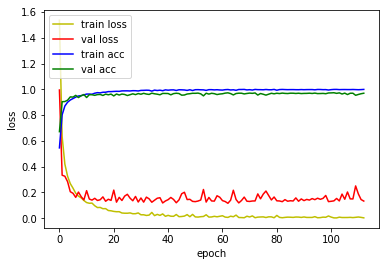

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.1603 - acc: 0.9626
Loss: 0.16025737308663038 Accuracy: 0.9626168



In [10]:
for i in range(4, 10):
    base = '1D_CNN_custom_3_DO_BN'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_DO_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_3_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(4, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_3_DO_BN_4_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 256)        1536      
_________________________________________________________________
batch_normalization_v1_45 (B (None, 16000, 256)        1024      
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 256)        0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 16000, 256)        327936    
_________________________________________________________________
batch_normalization_v1_46 (B (None, 16000, 256)        1024      
_________________________________________________________________
activation_46 (Activation)   (None, 16000, 256)        0         
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 5333

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.4635 - acc: 0.8719
Loss: 0.4635198420081926 Accuracy: 0.8718588

1D_CNN_custom_3_DO_BN_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_60 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_60 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_60 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_61 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_61 (Activation)   (None, 160

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.1704 - acc: 0.9516
Loss: 0.1703981090382492 Accuracy: 0.95160955

1D_CNN_custom_3_DO_BN_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_75 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_75 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_75 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_76 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_76 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_76 (Activation)   (None, 16

In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(4, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_3_DO_BN_4_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_45 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_46 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_46 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 5333

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.5852 - acc: 0.8690
Loss: 0.5851801105253669 Accuracy: 0.8689512

1D_CNN_custom_3_DO_BN_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_60 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_60 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_60 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_61 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_61 (Activation)   (None, 160

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2241 - acc: 0.9545
Loss: 0.22413124301273044 Accuracy: 0.9545171

1D_CNN_custom_3_DO_BN_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_75 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
batch_normalization_v1_75 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_75 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_76 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
batch_normalization_v1_76 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_76 (Activation)   (None, 16